# Training Models

### Setup Data

In [1]:
# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import multi_gpu_model, to_categorical

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle
import h5py

import sys, os, glob
sys.path.append("/home/bryanb/cuckoo-cli/")
import cuckoo_cl

if len(sys.argv) > 1 and sys.argv[1] == '0':
    prefix = '/mnt_blpc1/datax/scratch/bbrzycki/training/training2/'
else:
    prefix = '/datax/scratch/bbrzycki/training/training2/'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, num_labels=1, batch_size=32, dim=(32,1024), n_channels=1, n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.num_labels = num_labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_labels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/train/%s.npy' % ID
            X[i] = np.load(filename).reshape((*self.dim, self.n_channels))
            
            X[i] -= np.mean(X[i])
            X[i] /= np.std(X[i])

            # Store class
            y[i] = self.labels[ID]
#         y = to_categorical(y)

        return X, y

# dimensions of our images.
img_width, img_height = 32, 1024
                                                                 
tsamp = 1.4316557653333333

dir_name = '/datax/scratch/bbrzycki/training/training2/'
h5_datasets = '/datax/scratch/bbrzycki/training/training2/data/2sig/2sig.hdf5'
# validation_csv_fn = dir_name + 'train/validation_labels.csv'

batch_size = 64

# Parameters
params = {'dim': (32, 1024),
          'batch_size': batch_size,
          'n_channels': 1,
          'num_labels': 4,
          'shuffle': True}

Using TensorFlow backend.


In [2]:
# Datasets
partition = {'train' : [], 'validation' : []}
labels = {}

total_image_num = 120000
print(total_image_num)
train_num = int(total_image_num * 0.8)
validation_num = total_image_num - train_num

# max_drift = 31.225e-6
dbs = []
ids = []
save_labels = []
with h5py.File(h5_datasets, 'r') as f:
    
    # for 1 signal and 0 rfi
    for i in range(total_image_num):
        ID = '%06d' % i
        
        class_nums = f['train'][ID].attrs['class_nums']
        sig_db = f['train'][ID].attrs['sig_db']
        dbs.append(sig_db)
        
        ids.append(ID)

        start1, end1, lw1, snr1, label1, start2, end2, lw2, snr2, label2  = np.array(f['train'][ID]['signals_info']).flatten()
        # All between 0 and 1
        label = (start1 / 1024, end1 / 1024, start2 / 1024, end2 / 1024)
        labels[ID] = label
        save_labels.append(label)

partition['train'] = ids[:train_num]
partition['validation'] = ids[train_num:]
 
# labels = {key: (value / max_drift) for (key, value) in labels.items()}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

120000


In [3]:
save_labels = [val for (key, val) in labels.items()]

In [4]:
np.save('/datax/scratch/bbrzycki/training/training2/data/2sig/dbs.npy', dbs)
np.save('/datax/scratch/bbrzycki/training/training2/data/2sig/labels.npy', save_labels)

Load

In [2]:
total_image_num = 120000
print(total_image_num)
train_num = int(total_image_num * 0.8)
validation_num = total_image_num - train_num

ids = ['%06d' % i for i in range(total_image_num)]
dbs = np.load('/datax/scratch/bbrzycki/training/training2/data/2sig/dbs.npy')
save_labels = np.load('/datax/scratch/bbrzycki/training/training2/data/2sig/labels.npy')
labels = {('%06d' % i): save_labels[i] for i in range(total_image_num)}

# Generators
partition = {'train' : [], 'validation' : []}
partition['train'] = ids[:train_num]
partition['validation'] = ids[train_num:]

120000


In [3]:
batch_size = 64

# Parameters
params = {'dim': (32, 1024),
          'batch_size': batch_size,
          'n_channels': 1,
          'num_labels': 4,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [4]:
# keras.backend.clear_session()

# Design model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 1022, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 1022, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 1020, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 1020, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 510, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 508, 32)       9248      
_________________________________________________________________
activation_3 (Activation)    (None, 12, 508, 32)       0         
__________

In [ ]:
model_fn = dir_name + 'models/2sig/simple_cnn.h5'
history_fn = dir_name + 'models/2sig/simple_cnn_history'

epochs = 20

history = model.fit_generator(generator=training_generator,
                    steps_per_epoch=train_num // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_num // batch_size,
                    callbacks=[keras.callbacks.ModelCheckpoint(model_fn, monitor='loss', verbose=0, save_best_only=True, mode='auto'), 
                               keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001), 
                               keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose=0, mode='auto')])

model.save_weights(model_fn)
with open(history_fn, 'wb') as f:
    pickle.dump(history.history, f)

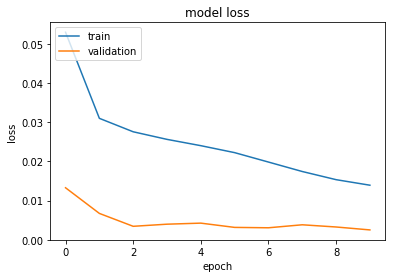

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Signal (db): 20
Label: (343.0, 504.0)
Prediction: (348.7, 508.4)
Sqrt of Error:  7.193618857255543


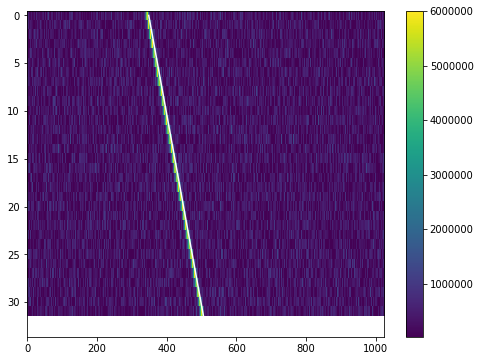

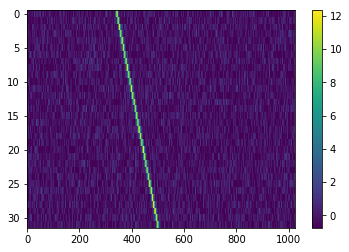

In [61]:
with h5py.File(h5_datasets, 'r') as f:
    split = 4000
    index = np.random.randint(0, split * 6)
    ID = '%06d' % index
        
    class_nums = f['test'][ID].attrs['class_nums']
    sig_db = f['test'][ID].attrs['sig_db']
    print('Signal (db):', sig_db)
    

    start1, end1, lw1, snr1, label1, start2, end2, lw2, snr2, label2 = np.array(f['test'][ID]['signals_info']).flatten()
    # All between 0 and 1
    label = (start1 / 1024, end1 / 1024, start2 / 1024, end2 / 1024)
    print('Label:', (start_index, end_index))

filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
frame = np.load(filename)
X = np.copy(frame).reshape((1, 32, 1024, 1))
X -= np.mean(X)
X /= np.std(X)

p_start1, p_end1, p_start2, p_end2 = model.predict(X)[0]
print('Predictions: (%0.1f, %0.1f), (%0.1f, %0.1f)' % (p_start1 / 1024, p_end1 / 1024, p_start2 / 1024, p_end2 / 1024))

print('Sqrt of Error (index units): %0.2f' % (1024 * np.sqrt(np.mean((label[0] - p_start1)**2 + (label[1] - p_end1)**2) + (label[2] - p_start2)**2 + (label[3] - p_end2)**2))))

fig = plt.figure(figsize=(8,6))
plt.imshow(frame, aspect='auto')
plt.plot([p_start1 * 1024, p_end1 * 1024], [0, 32], 'w')
plt.plot([p_start2 * 1024, p_end2 * 1024], [0, 32], 'w')
plt.colorbar()
plt.show()

plt.imshow(X.reshape(32, 1024), aspect='auto')
plt.colorbar()
plt.show()



### Functional Model ResNet

In [6]:
from keras.layers import Conv2D, Input, Dense
from keras.models import Model

def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    return keras.layers.add([x, conv])

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0 = Residual(inputs, 32)
strided0 = Conv2D(32, (3, 3), strides=2)(r0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(64, (3, 3), strides=2)(r1)

r2 = Residual(strided1, 64)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)

# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation='relu')(flat)
dense1 = Dense(64, activation='relu')(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(4, activation='linear')(drop0)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 1024, 1)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 1024, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 32, 1024, 32) 0           input_1[0][0]                    
                                                                 conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 15, 511, 32)  9248        add_1[0][0]                      
__________

In [ ]:
model_fn = dir_name + 'models/2sig/resnet.h5'
history_fn = dir_name + 'models/2sig/resnet_history'

epochs = 10

# Train
history = model.fit_generator(generator=training_generator,
                    steps_per_epoch=train_num // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_num // batch_size,
                    callbacks=[keras.callbacks.ModelCheckpoint(model_fn, monitor='loss', verbose=0, save_best_only=True, mode='auto'), 
                               keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001), 
                               keras.callbacks.EarlyStopping(monitor='loss', patience=10,verbose=0, mode='auto')])

model.save_weights(model_fn)
with open(history_fn, 'wb') as f:
    pickle.dump(history.history, f)


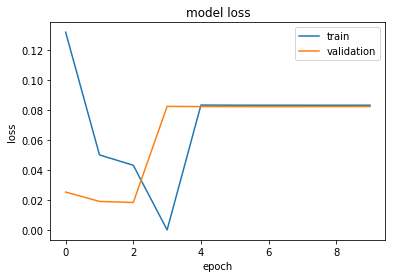

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
loss[3] = 0
# "Loss"
plt.plot(loss)
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Inception

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Conv2D, Input, Dense
from keras.models import Model

def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    return keras.layers.add([x, conv])

def Inception(x, layers=64):
    tower_1 = Conv2D(layers, (1, 1), padding='same', activation='relu')(x)
    tower_1 = Conv2D(layers, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(layers, (1, 1), padding='same', activation='relu')(x)
    tower_2 = Conv2D(layers, (5, 5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower_3 = Conv2D(layers, (1, 1), padding='same', activation='relu')(tower_3)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)
    return output

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
i0 = Inception(inputs, 32)
strided0 = Conv2D(32, (5, 3), strides=(1, 2))(i0)
c1 = Conv2D(32, (3, 3), strides=2)(strided0)

# r1 = Residual(strided0, 32)
# strided1 = Conv2D(64, (3, 3), strides=2)(r1)

# r2 = Residual(strided1, 64)
# strided2 = Conv2D(64, (3, 3), strides=2)(r2)

# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(c1)
dense0 = Dense(32, activation='relu')(flat)
dense1 = Dense(64, activation='relu')(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(4, activation='linear')(drop0)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='inception_model.png', show_shapes=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 1024, 1)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 1024, 32) 64          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 1024, 32) 64          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 1024, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 

In [ ]:
model_fn = dir_name + 'models/2sig/inception.h5'
history_fn = dir_name + 'models/2sig/inception_history'

epochs = 10
batch_size = 32

# Train
history = model.fit_generator(generator=training_generator,
                    steps_per_epoch=train_num // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_num // batch_size,
                    callbacks=[keras.callbacks.ModelCheckpoint(model_fn, monitor='loss', verbose=0, save_best_only=True, mode='auto'), 
                               keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001), 
                               keras.callbacks.EarlyStopping(monitor='loss', patience=10,verbose=0, mode='auto')])

model.save_weights(model_fn)
with open(history_fn, 'wb') as f:
    pickle.dump(history.history, f)

%matplotlib inline
import matplotlib.pyplot as plt
# "Loss"
plt.plot(loss = history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# START

In [62]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='linear'))

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model.summary()

model_fn = dir_name + 'models/2sig/simple_cnn.h5'
history_fn = dir_name + 'models/2sig/simple_cnn_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 30, 1022, 32)      320       
_________________________________________________________________
activation_30 (Activation)   (None, 30, 1022, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 1020, 32)      9248      
_________________________________________________________________
activation_31 (Activation)   (None, 28, 1020, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 510, 32)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 508, 32)       9248      
_________________________________________________________________
activation_32 (Activation)   (None, 12, 508, 32)       0         
__________

In [63]:
from keras.layers import Conv2D, Input, Dense, BatchNormalization
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0 = Residual(inputs, 32)
strided0 = Conv2D(32, (3, 3), strides=2)(r0)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(64, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 64)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
dense1 = Dense(64, activation=activation)(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(4, activation='linear')(drop0)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model1 = Model(inputs=inputs, outputs=predictions)
model1.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model1.summary()

model1_fn = dir_name + 'models/2sig/%s_resnet.h5' % activation
history1_fn = dir_name + 'models/2sig/%s_resnet_history' % activation

model1.load_weights(model1_fn)
with open(history1_fn, 'rb') as f:
    history1 = pickle.load(f)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 1024, 1)  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 1024, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
add_9 (Add)                     (None, 32, 1024, 32) 0           input_4[0][0]                    
                                                                 conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 32, 1024, 32) 0           add_9[0][0]                      
__________

In [64]:
from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2)(inputs)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(4, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model2 = Model(inputs=inputs, outputs=predictions)
model2.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model2.summary()

model2_fn = dir_name + 'models/2sig/resnet_2chans.h5'
history2_fn = dir_name + 'models/2sig/resnet_2chans_history'

model2.load_weights(model2_fn)
with open(history2_fn, 'rb') as f:
    history2 = pickle.load(f)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 1024, 2)  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 15, 511, 32)  608         input_5[0][0]                    
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 15, 511, 32)  0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 15, 511, 32)  9248        activation_42[0][0]              
__________________________________________________________________________________________________
add_12 (Ad

Signal (db): 20
Label: [813. 813. 692. 696.]
Prediction: [748.2938  748.2938  336.95575 833.84894]
Sqrt of Error (index units): 195.85
Prediction1: [825.10754 825.1076  570.2523  618.4489 ]
Sqrt of Error (index units): 72.68
Prediction2: [783.68506 783.68506 651.25824 745.5577 ]
Sqrt of Error (index units): 38.19


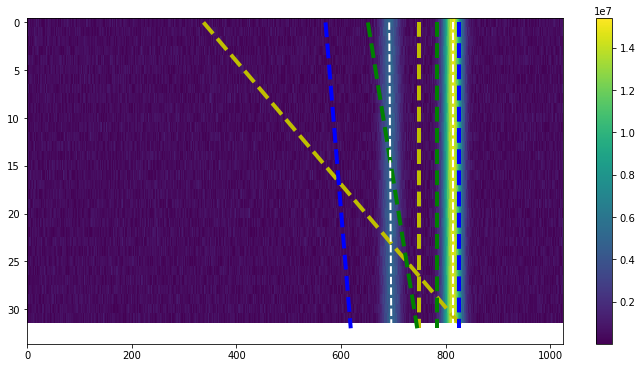

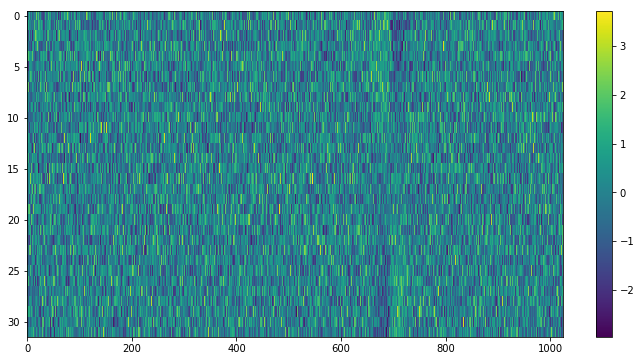

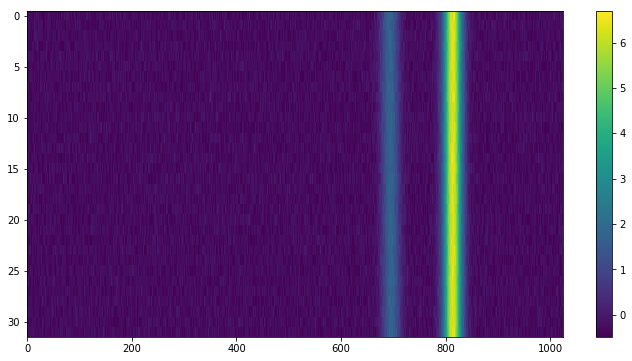

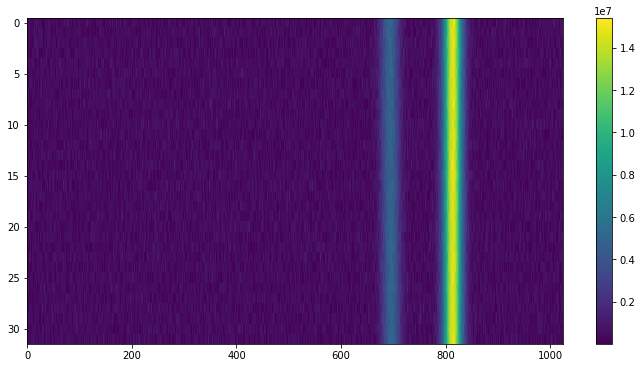

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

with h5py.File(h5_datasets, 'r') as f:
    split_num = 4000
    index = np.random.randint(0, split_num * 6)
    ID = '%06d' % index
        
    class_nums = f['test'][ID].attrs['class_nums']
    sig_db = f['test'][ID].attrs['sig_db']
    print('Signal (db):', sig_db)

    start1, end1, lw1, snr1, label1, start2, end2, lw2, snr2, label2  = np.array(f['test'][ID]['signals_info']).flatten()
    # All between 0 and 1
    label = np.array([start1 / 1024, end1 / 1024, start2 / 1024, end2 / 1024])
    print('Label:', (label*1024))
        
filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
frame = np.load(filename)
X = np.copy(frame).reshape((1, 32, 1024, 1))
X -= np.mean(X)
X /= np.std(X)

X1 = np.load(filename)
X2 = np.copy(X1)
            
X1 -= np.mean(X1)
X1 /= np.std(X1)

X2 -= np.mean(X2, axis=0)
X2 /= np.std(X2, axis=0)

Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))



prediction = model.predict(X)[0]
prediction1 = model1.predict(X)[0]

prediction2 = model2.predict(Xstack)[0]

print('Prediction:', (prediction*1024))
print('Sqrt of Error (index units): %0.2f' % (1024 * np.sqrt(np.mean((label - prediction)**2))))


print('Prediction1:', (prediction1*1024))
print('Sqrt of Error (index units): %0.2f' % (1024 * np.sqrt(np.mean((label - prediction1)**2))))


print('Prediction2:', (prediction2*1024))
print('Sqrt of Error (index units): %0.2f' % (1024 * np.sqrt(np.mean((label - prediction2)**2))))


fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.plot([prediction[0] * 1024, prediction[1] * 1024], [0, 32], 'y', linestyle='--', lw=4)
plt.plot([prediction[2] * 1024, prediction[3] * 1024], [0, 32], 'y', linestyle='--', lw=4)

plt.plot([prediction1[0] * 1024, prediction1[1] * 1024], [0, 32], 'b', linestyle='--', lw=4)
plt.plot([prediction1[2] * 1024, prediction1[3] * 1024], [0, 32], 'b', linestyle='--', lw=4)

plt.plot([prediction2[0] * 1024, prediction2[1] * 1024], [0, 32], 'g', linestyle='--', lw=4)
plt.plot([prediction2[2] * 1024, prediction2[3] * 1024], [0, 32], 'g', linestyle='--', lw=4)


plt.plot([label[0] * 1024, label[1] * 1024], [0, 32], 'w--', lw=2)
plt.plot([label[2] * 1024, label[3] * 1024], [0, 32], 'w--', lw=2)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(12,6))
plt.imshow(X2.reshape(32, 1024), aspect='auto')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(12,6))
plt.imshow(X.reshape(32, 1024), aspect='auto')
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.colorbar()
plt.show()


